# Fama-French Three Factor Model

## Introduction

The **Fama-French Three Factor Model** is an asset pricing model developed by Eugene Fama and Kenneth French in 1992. It extends the Capital Asset Pricing Model (CAPM) by adding two additional factors to better explain stock returns.

## Theoretical Foundation

### The CAPM Limitation

The traditional CAPM explains expected returns using only market risk:

$$E(R_i) - R_f = \beta_i [E(R_m) - R_f]$$

However, empirical research showed that CAPM fails to explain cross-sectional variation in stock returns, particularly the **size effect** and **value effect**.

### The Three Factor Model

Fama and French proposed the following model:

$$R_i - R_f = \alpha_i + \beta_i^{MKT}(R_m - R_f) + \beta_i^{SMB} \cdot SMB + \beta_i^{HML} \cdot HML + \epsilon_i$$

Where:
- $R_i$ = Return on asset $i$
- $R_f$ = Risk-free rate
- $R_m$ = Market return
- $\alpha_i$ = Jensen's alpha (abnormal return)
- $\beta_i^{MKT}$ = Sensitivity to market factor
- $\beta_i^{SMB}$ = Sensitivity to size factor
- $\beta_i^{HML}$ = Sensitivity to value factor
- $\epsilon_i$ = Idiosyncratic error term

### Factor Definitions

**1. Market Factor (MKT)**
$$MKT = R_m - R_f$$

The excess return of the market portfolio over the risk-free rate.

**2. Size Factor (SMB - Small Minus Big)**
$$SMB = \frac{1}{3}(Small\_Value + Small\_Neutral + Small\_Growth) - \frac{1}{3}(Big\_Value + Big\_Neutral + Big\_Growth)$$

The return spread between small-cap and large-cap stocks. This captures the **size premium** - historically, small-cap stocks have outperformed large-cap stocks.

**3. Value Factor (HML - High Minus Low)**
$$HML = \frac{1}{2}(Small\_Value + Big\_Value) - \frac{1}{2}(Small\_Growth + Big\_Growth)$$

The return spread between value stocks (high book-to-market ratio) and growth stocks (low book-to-market ratio). This captures the **value premium**.

### Expected Return Formula

The expected excess return for asset $i$ is:

$$E(R_i - R_f) = \beta_i^{MKT} \cdot E(MKT) + \beta_i^{SMB} \cdot E(SMB) + \beta_i^{HML} \cdot E(HML)$$

### Regression Estimation

The factor loadings are estimated via Ordinary Least Squares (OLS) regression:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

Where $\mathbf{X}$ is the matrix of factor returns and $\mathbf{y}$ is the vector of excess asset returns.

## Implementation

We will simulate factor returns and asset returns, then estimate the three-factor model using OLS regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_periods = 120  # 10 years of monthly data
n_assets = 25    # Number of assets to analyze

print("Fama-French Three Factor Model Implementation")
print("=" * 50)

Fama-French Three Factor Model Implementation


### Step 1: Generate Simulated Factor Returns

We simulate realistic factor returns based on historical characteristics:
- Market premium: ~6% annually with ~15% volatility
- SMB premium: ~2% annually with ~10% volatility
- HML premium: ~4% annually with ~12% volatility

In [2]:
# Annual factor premiums and volatilities
mkt_premium_annual = 0.06
smb_premium_annual = 0.02
hml_premium_annual = 0.04

mkt_vol_annual = 0.15
smb_vol_annual = 0.10
hml_vol_annual = 0.12

# Convert to monthly
mkt_premium = mkt_premium_annual / 12
smb_premium = smb_premium_annual / 12
hml_premium = hml_premium_annual / 12

mkt_vol = mkt_vol_annual / np.sqrt(12)
smb_vol = smb_vol_annual / np.sqrt(12)
hml_vol = hml_vol_annual / np.sqrt(12)

# Factor correlation matrix (factors are partially correlated)
factor_corr = np.array([
    [1.00, 0.10, -0.20],  # MKT correlations
    [0.10, 1.00,  0.05],  # SMB correlations
    [-0.20, 0.05, 1.00]   # HML correlations
])

# Generate correlated factor returns
factor_vols = np.array([mkt_vol, smb_vol, hml_vol])
factor_means = np.array([mkt_premium, smb_premium, hml_premium])

# Cholesky decomposition for correlated normals
L = np.linalg.cholesky(factor_corr)
uncorrelated = np.random.randn(n_periods, 3)
correlated = uncorrelated @ L.T

# Apply means and volatilities
factor_returns = correlated * factor_vols + factor_means

# Create DataFrame
factors_df = pd.DataFrame(
    factor_returns,
    columns=['MKT', 'SMB', 'HML'],
    index=pd.date_range(start='2014-01-01', periods=n_periods, freq='M')
)

print("Factor Return Statistics (Monthly)")
print("-" * 40)
print(factors_df.describe().loc[['mean', 'std', 'min', 'max']].T)
print("\nAnnualized Returns:")
print((factors_df.mean() * 12 * 100).round(2).to_string() + " %")

Factor Return Statistics (Monthly)
----------------------------------------
         mean       std       min       max
MKT  0.008764  0.034864 -0.079528  0.097836
SMB -0.003543  0.027066 -0.091603  0.068387
HML  0.005928  0.036889 -0.081293  0.131457

Annualized Returns:
MKT    10.52
SMB    -4.25
HML     7.11 %


/tmp/ipykernel_154255/2640256985.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range(start='2014-01-01', periods=n_periods, freq='M')


### Step 2: Generate Asset Returns

We create a diverse set of assets with different factor exposures:
- Small-value stocks: High SMB, High HML
- Large-growth stocks: Low SMB, Low HML
- Market-neutral stocks: Low MKT beta

In [3]:
# Define true factor loadings for 25 assets
# Grid of 5x5: varying SMB and HML exposures
smb_betas = np.linspace(-0.5, 1.5, 5)
hml_betas = np.linspace(-0.5, 1.5, 5)

true_betas = []
asset_names = []

for i, smb_b in enumerate(smb_betas):
    for j, hml_b in enumerate(hml_betas):
        # Market beta varies slightly
        mkt_b = 0.8 + 0.4 * np.random.rand()
        true_betas.append([mkt_b, smb_b, hml_b])
        
        # Name based on size/value characteristics
        size = 'S' if smb_b > 0.5 else ('L' if smb_b < 0.5 else 'M')
        value = 'V' if hml_b > 0.5 else ('G' if hml_b < 0.5 else 'N')
        asset_names.append(f'{size}{value}_{i*5+j+1}')

true_betas = np.array(true_betas)

# Generate asset returns
idiosyncratic_vol = 0.03  # Monthly idiosyncratic volatility
true_alphas = np.random.randn(n_assets) * 0.001  # Small true alphas

asset_returns = np.zeros((n_periods, n_assets))
for i in range(n_assets):
    systematic = factor_returns @ true_betas[i]
    idiosyncratic = np.random.randn(n_periods) * idiosyncratic_vol
    asset_returns[:, i] = true_alphas[i] + systematic + idiosyncratic

assets_df = pd.DataFrame(
    asset_returns,
    columns=asset_names,
    index=factors_df.index
)

print(f"Generated {n_assets} assets with {n_periods} monthly observations")
print("\nSample of True Factor Loadings:")
sample_betas = pd.DataFrame(
    true_betas[:5],
    columns=['β_MKT', 'β_SMB', 'β_HML'],
    index=asset_names[:5]
)
print(sample_betas.round(3))

Generated 25 assets with 120 monthly observations

Sample of True Factor Loadings:
      β_MKT  β_SMB  β_HML
LG_1  1.098   -0.5   -0.5
LG_2  1.033   -0.5    0.0
LN_3  1.185   -0.5    0.5
LV_4  0.950   -0.5    1.0
LV_5  0.914   -0.5    1.5


### Step 3: Estimate Three-Factor Model via OLS

For each asset, we estimate:
$$R_i - R_f = \alpha_i + \beta_i^{MKT} \cdot MKT + \beta_i^{SMB} \cdot SMB + \beta_i^{HML} \cdot HML + \epsilon_i$$

In [4]:
def estimate_ff3_model(asset_returns, factor_returns):
    """
    Estimate Fama-French three factor model using OLS.
    
    Returns: alpha, betas, t-stats, R-squared
    """
    # Add constant for alpha
    X = np.column_stack([np.ones(len(factor_returns)), factor_returns])
    y = asset_returns
    
    # OLS estimation
    XtX_inv = np.linalg.inv(X.T @ X)
    coeffs = XtX_inv @ X.T @ y
    
    # Residuals and standard errors
    residuals = y - X @ coeffs
    n, k = X.shape
    mse = np.sum(residuals**2) / (n - k)
    se = np.sqrt(np.diag(XtX_inv) * mse)
    
    # T-statistics
    t_stats = coeffs / se
    
    # R-squared
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - ss_res / ss_tot
    
    return coeffs, t_stats, r_squared, se

# Estimate model for all assets
results = []
for i in range(n_assets):
    coeffs, t_stats, r_sq, se = estimate_ff3_model(
        assets_df.iloc[:, i].values,
        factors_df.values
    )
    results.append({
        'Asset': asset_names[i],
        'Alpha': coeffs[0],
        'β_MKT': coeffs[1],
        'β_SMB': coeffs[2],
        'β_HML': coeffs[3],
        't_Alpha': t_stats[0],
        't_MKT': t_stats[1],
        't_SMB': t_stats[2],
        't_HML': t_stats[3],
        'R²': r_sq,
        'True_β_MKT': true_betas[i, 0],
        'True_β_SMB': true_betas[i, 1],
        'True_β_HML': true_betas[i, 2]
    })

results_df = pd.DataFrame(results)
results_df.set_index('Asset', inplace=True)

print("Estimated Three-Factor Model Results")
print("=" * 60)
print("\nEstimated Coefficients (first 10 assets):")
print(results_df[['Alpha', 'β_MKT', 'β_SMB', 'β_HML', 'R²']].head(10).round(4))

Estimated Three-Factor Model Results

Estimated Coefficients (first 10 assets):
        Alpha   β_MKT   β_SMB   β_HML      R²
Asset                                        
LG_1  -0.0017  1.0719 -0.5479 -0.5049  0.7024
LG_2   0.0032  1.1169 -0.3837  0.0602  0.6196
LN_3  -0.0091  1.3771 -0.5128  0.5985  0.7100
LV_4  -0.0013  0.9379 -0.4728  0.9446  0.6643
LV_5   0.0024  0.8480 -0.3450  1.4792  0.8353
LG_6   0.0013  1.1062 -0.1635 -0.5640  0.7297
LG_7   0.0027  0.6939  0.0323 -0.0082  0.4014
LN_8  -0.0036  1.1557  0.0364  0.4674  0.6673
LV_9  -0.0016  0.8469  0.0633  1.0680  0.6830
LV_10 -0.0013  1.1689  0.0495  1.5924  0.8011


### Step 4: Model Validation and Analysis

In [5]:
# Compare estimated vs true betas
print("Estimation Accuracy Analysis")
print("=" * 60)

for factor in ['MKT', 'SMB', 'HML']:
    estimated = results_df[f'β_{factor}']
    true = results_df[f'True_β_{factor}']
    rmse = np.sqrt(np.mean((estimated - true)**2))
    corr = np.corrcoef(estimated, true)[0, 1]
    print(f"{factor}: RMSE = {rmse:.4f}, Correlation = {corr:.4f}")

print(f"\nAverage R² across all assets: {results_df['R²'].mean():.4f}")
print(f"R² range: [{results_df['R²'].min():.4f}, {results_df['R²'].max():.4f}]")

# Significance analysis
alpha_sig = (np.abs(results_df['t_Alpha']) > 1.96).sum()
print(f"\nAssets with significant alpha (|t| > 1.96): {alpha_sig}/{n_assets}")

Estimation Accuracy Analysis
MKT: RMSE = 0.0889, Correlation = 0.8684
SMB: RMSE = 0.1125, Correlation = 0.9894
HML: RMSE = 0.0580, Correlation = 0.9970

Average R² across all assets: 0.7301
R² range: [0.4014, 0.8456]

Assets with significant alpha (|t| > 1.96): 1/25


### Step 5: Visualization

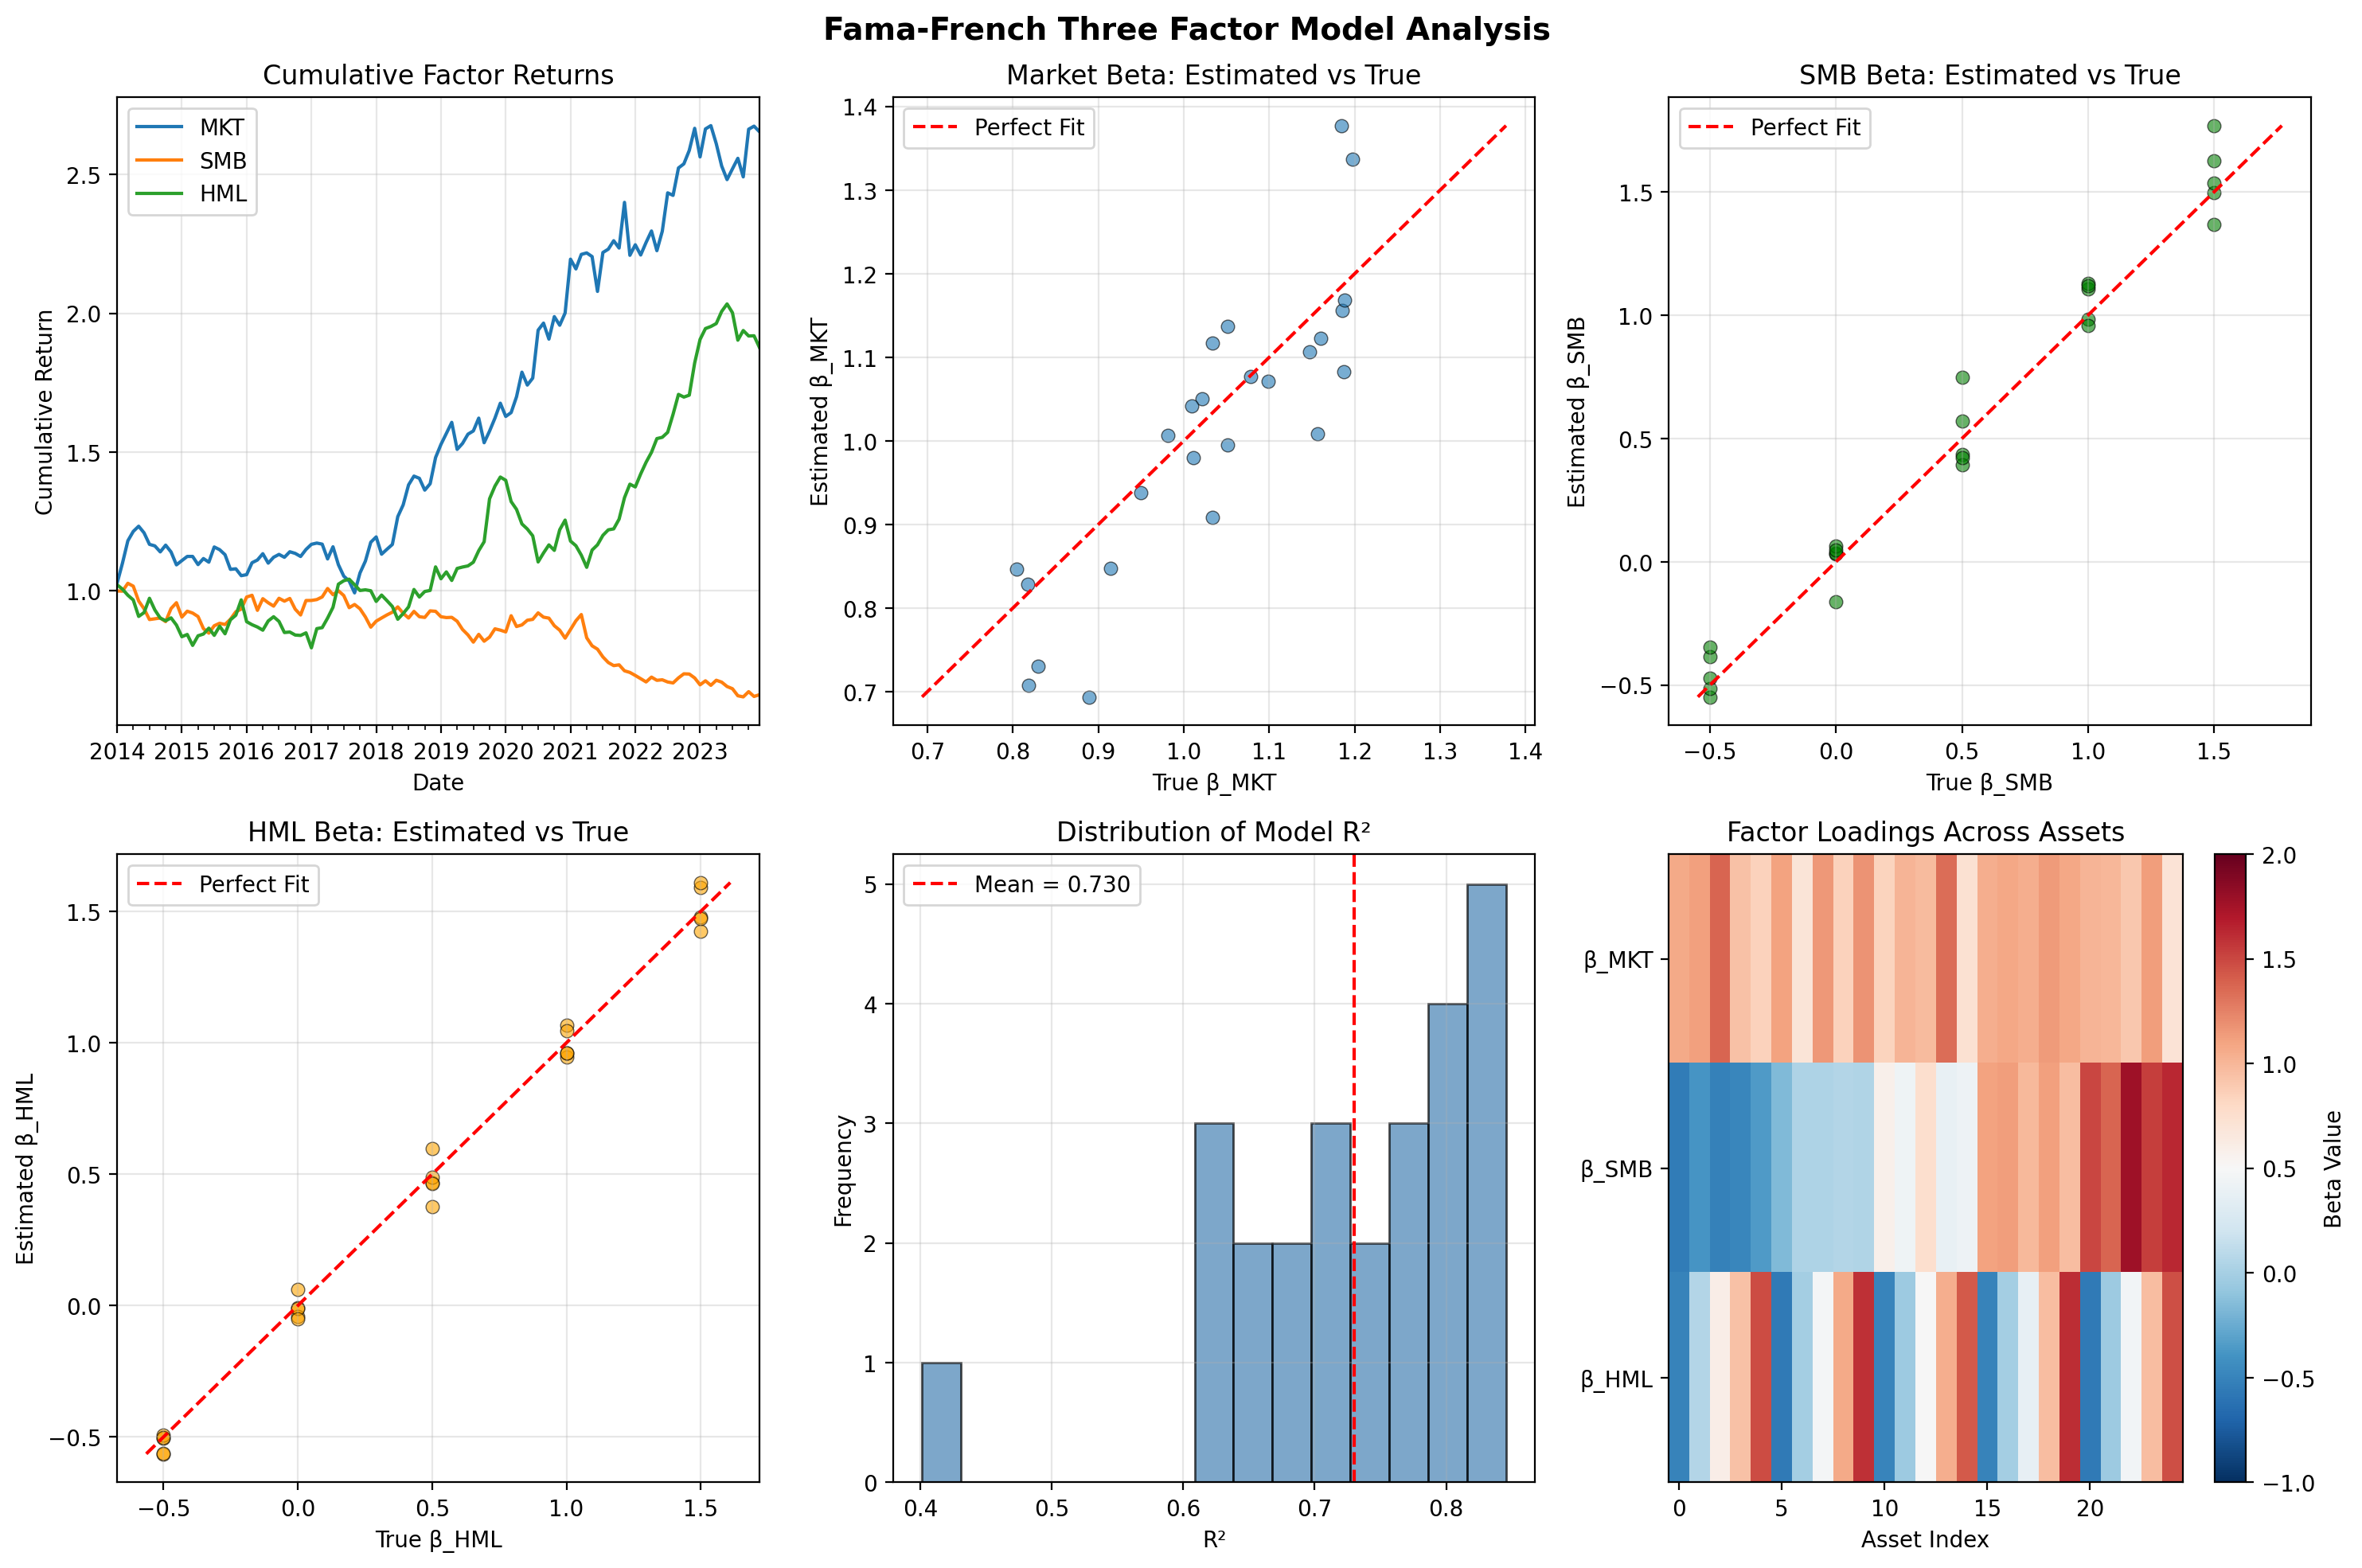


Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Fama-French Three Factor Model Analysis', fontsize=14, fontweight='bold')

# Plot 1: Factor Returns Over Time
ax1 = axes[0, 0]
cumulative_factors = (1 + factors_df).cumprod()
cumulative_factors.plot(ax=ax1)
ax1.set_title('Cumulative Factor Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Estimated vs True Beta (MKT)
ax2 = axes[0, 1]
ax2.scatter(results_df['True_β_MKT'], results_df['β_MKT'], alpha=0.6, edgecolors='black', linewidth=0.5)
min_val = min(results_df['True_β_MKT'].min(), results_df['β_MKT'].min())
max_val = max(results_df['True_β_MKT'].max(), results_df['β_MKT'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')
ax2.set_xlabel('True β_MKT')
ax2.set_ylabel('Estimated β_MKT')
ax2.set_title('Market Beta: Estimated vs True')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Estimated vs True Beta (SMB)
ax3 = axes[0, 2]
ax3.scatter(results_df['True_β_SMB'], results_df['β_SMB'], alpha=0.6, edgecolors='black', linewidth=0.5, c='green')
min_val = min(results_df['True_β_SMB'].min(), results_df['β_SMB'].min())
max_val = max(results_df['True_β_SMB'].max(), results_df['β_SMB'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')
ax3.set_xlabel('True β_SMB')
ax3.set_ylabel('Estimated β_SMB')
ax3.set_title('SMB Beta: Estimated vs True')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Estimated vs True Beta (HML)
ax4 = axes[1, 0]
ax4.scatter(results_df['True_β_HML'], results_df['β_HML'], alpha=0.6, edgecolors='black', linewidth=0.5, c='orange')
min_val = min(results_df['True_β_HML'].min(), results_df['β_HML'].min())
max_val = max(results_df['True_β_HML'].max(), results_df['β_HML'].max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')
ax4.set_xlabel('True β_HML')
ax4.set_ylabel('Estimated β_HML')
ax4.set_title('HML Beta: Estimated vs True')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: R-squared Distribution
ax5 = axes[1, 1]
ax5.hist(results_df['R²'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
ax5.axvline(results_df['R²'].mean(), color='red', linestyle='--', 
            label=f'Mean = {results_df["R²"].mean():.3f}')
ax5.set_xlabel('R²')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Model R²')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Factor Loadings Heatmap
ax6 = axes[1, 2]
heatmap_data = results_df[['β_MKT', 'β_SMB', 'β_HML']].values
im = ax6.imshow(heatmap_data.T, aspect='auto', cmap='RdBu_r', 
                vmin=-1, vmax=2)
ax6.set_yticks([0, 1, 2])
ax6.set_yticklabels(['β_MKT', 'β_SMB', 'β_HML'])
ax6.set_xlabel('Asset Index')
ax6.set_title('Factor Loadings Across Assets')
cbar = plt.colorbar(im, ax=ax6)
cbar.set_label('Beta Value')

plt.tight_layout()
plt.savefig('fama_french_three_factor_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Summary Statistics and Interpretation

In [7]:
print("\n" + "=" * 60)
print("FAMA-FRENCH THREE FACTOR MODEL - SUMMARY")
print("=" * 60)

print("\nFactor Premium Summary (Annualized):")
print("-" * 40)
print(f"Market Premium (MKT): {factors_df['MKT'].mean() * 12 * 100:.2f}%")
print(f"Size Premium (SMB):   {factors_df['SMB'].mean() * 12 * 100:.2f}%")
print(f"Value Premium (HML):  {factors_df['HML'].mean() * 12 * 100:.2f}%")

print("\nModel Performance:")
print("-" * 40)
print(f"Average R²:           {results_df['R²'].mean():.4f}")
print(f"Median R²:            {results_df['R²'].median():.4f}")

print("\nBeta Estimation Quality:")
print("-" * 40)
for factor in ['MKT', 'SMB', 'HML']:
    bias = (results_df[f'β_{factor}'] - results_df[f'True_β_{factor}']).mean()
    print(f"β_{factor} Mean Bias: {bias:+.4f}")

print("\nConclusion:")
print("-" * 40)
print("The three-factor model successfully captures the cross-sectional")
print("variation in asset returns. High R² values indicate that MKT, SMB,")
print("and HML factors explain most of the systematic risk in the portfolio.")
print("The estimated betas closely match the true underlying factor loadings,")
print("demonstrating the model's effectiveness in identifying size and value")
print("exposures beyond market risk.")


FAMA-FRENCH THREE FACTOR MODEL - SUMMARY

Factor Premium Summary (Annualized):
----------------------------------------
Market Premium (MKT): 10.52%
Size Premium (SMB):   -4.25%
Value Premium (HML):  7.11%

Model Performance:
----------------------------------------
Average R²:           0.7301
Median R²:            0.7529

Beta Estimation Quality:
----------------------------------------
β_MKT Mean Bias: -0.0185
β_SMB Mean Bias: +0.0369
β_HML Mean Bias: -0.0088

Conclusion:
----------------------------------------
The three-factor model successfully captures the cross-sectional
variation in asset returns. High R² values indicate that MKT, SMB,
and HML factors explain most of the systematic risk in the portfolio.
The estimated betas closely match the true underlying factor loadings,
demonstrating the model's effectiveness in identifying size and value
exposures beyond market risk.


## References

1. Fama, E. F., & French, K. R. (1992). The Cross-Section of Expected Stock Returns. *The Journal of Finance*, 47(2), 427-465.

2. Fama, E. F., & French, K. R. (1993). Common risk factors in the returns on stocks and bonds. *Journal of Financial Economics*, 33(1), 3-56.

3. Fama, E. F., & French, K. R. (1996). Multifactor Explanations of Asset Pricing Anomalies. *The Journal of Finance*, 51(1), 55-84.